# Import Python Libaries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size':20})
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy import stats

from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import operator

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle, class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# install tensorflow 2.0
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# check the availability of GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### GloVe Pretrained Word Embedding loading

In [0]:
# Load GloVe Embeddings
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


# Import cleaned data

In [0]:
data = pd.read_csv('/gdrive/My Drive/cleaned_data.csv', encoding = "ISO-8859-1")

In [0]:
data.head(5)

,Unnamed: 0,_unit_id,positivity,relevance,date,texts
0,0,842613455,3.0,1,8/14/91,yield cd fall late week new york yield cert...
1,1,842613456,NaN,0,8/21/07,morning brief white house seek limit child i...
2,2,842613457,NaN,0,11/14/91,banking bill negotiator set compromise plan...
3,3,842613458,NaN,0,6/16/86,manager journal sniff drug abuser quick fix ...
4,4,842613459,3.0,1,10/4/02,currency trading dollar remain tight range a...


# Text Classification

In [0]:
data = data[['texts','relevance']]

## Oversampling
Oversampling the minority by looking for the synonyms of each word in minor class

In [0]:
# use WordNet to find synonyms of each word and oversample the minor class
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# minor class data set
df = data[data['relevance']==1]

In [0]:
# function to oversample data
def oversample(wordlist): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)  # find synonyms list of each word
        synonym = random.choice(list(synonyms))  # random select one sysnonym to replace the original word
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]]) # join the list of synonyms to a new sentence
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','relevance'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['relevance']  = df['relevance']
  return augmented_sentences

In [0]:
# oversample the minor class data twice
sentence = df['texts']
word_list = sentence.str.split()
data_cleaned = data[['texts','relevance']]

random.seed(45)
data_cleaned = data_cleaned.append(oversample(word_list))

random.seed(98)
data_cleaned = data_cleaned.append(oversample(word_list))

In [0]:
dist = data_cleaned.groupby('relevance').count()
dist

,texts
relevance,
0,6571
1,4260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


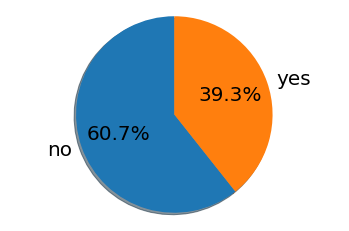

In [0]:
# pie chart of distribution of news relevance
fig1, ax1 = plt.subplots()
sizes = dist.values
label = ['no', 'yes']
plt.rcParams.update({'font.size':20})
ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.set_title('relevance to US economy')
ax1.axis('equal')    
plt.show()

In [0]:
dist = data.groupby('relevance').count()
dist

,texts
relevance,
0,6571
1,1420


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


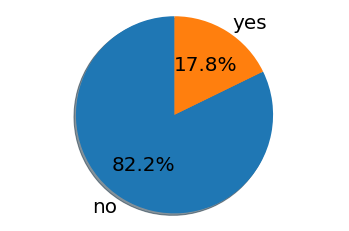

In [0]:
# pie chart of distribution of news relevance
fig1, ax1 = plt.subplots()
sizes = dist.values
label = ['no', 'yes']
plt.rcParams.update({'font.size':20})
ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.set_title('relevance to US economy')
ax1.axis('equal')    
plt.show()

In [0]:
# to ramdom shuffle data
data_cleaned = shuffle(data_cleaned)

In [0]:
# reset data index
data_cleaned = data_cleaned.reset_index()

In [0]:
data_cleaned.head(5)

,index,texts,relevance
0,6880,narrow trading prevail new york april mo...,0
1,690,opportunity knock european corporate bond safe...,0
2,7220,new limit impose credit card company federal g...,0
3,5227,mitchell claim vote bar capital gain tax cut ...,0
4,7292,plan curb drug price reject justice call link ...,0


## LSTM

In [0]:
# some configuration
MAX_SEQUENCE_LENGTH = 432   # max sentence length 432 words
EMBEDDING_DIM = 300    # word vector dimension


### Word Embedding Weights

In [0]:
# load in pre-trained word vectors
# shape: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data_cleaned['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Loading word vectors...
Found 42888 unique tokens.


In [0]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
8484, or 19.78% of total 42888 unique words are not covered


### Padding

In [0]:
sequences = tokenizer.texts_to_sequences(data_cleaned['texts'].values)
texts = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', texts.shape)

Shape of test data tensor: (10831, 432)


### Model

#### Select learning rate

##### LSTM_method 1 (5E-5)

In [0]:
labels = data_cleaned['relevance'].values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=7)

Building Bi-LSTM model...
Training model...
lr: 1.1481536214968828e-08
lr: 1.202264434617413e-08
lr: 1.2589254117941673e-08
lr: 1.3182567385564071e-08
lr: 1.3803842646028848e-08
lr: 1.4454397707459274e-08
lr: 1.5135612484362082e-08
lr: 1.5848931924611136e-08
lr: 1.6595869074375607e-08
lr: 1.7378008287493753e-08
lr: 1.8197008586099835e-08
lr: 1.9054607179632472e-08
lr: 1.9952623149688796e-08
lr: 2.0892961308540398e-08
lr: 2.1877616239495524e-08
lr: 2.2908676527677733e-08
lr: 2.3988329190194904e-08
lr: 2.51188643150958e-08
lr: 2.6302679918953818e-08
lr: 2.7542287033381663e-08
lr: 2.884031503126606e-08
lr: 3.019951720402016e-08
lr: 3.16227766016838e-08
lr: 3.311311214825911e-08
lr: 3.4673685045253164e-08
lr: 3.630780547701014e-08
lr: 3.801893963205611e-08
lr: 3.981071705534972e-08
lr: 4.1686938347033536e-08
lr: 4.36515832240166e-08
lr: 4.570881896148751e-08
lr: 4.786300923226384e-08
lr: 5.011872336272722e-08
lr: 5.248074602497726e-08
lr: 5.4954087385762456e-08
lr: 5.75439937337157e-08
lr:

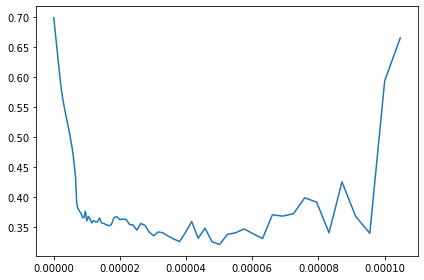

1084/1084 [==============================] - 1s 479us/sample - loss: 0.6937 - tp: 310.0000 - fp: 90.0000 - tn: 573.0000 - fn: 111.0000 - accuracy: 0.8146 - precision: 0.7750 - recall: 0.7363 - auc: 0.8592


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset

from keras.callbacks import LearningRateScheduler

print('Building Bi-LSTM model...')
cvscores = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc', 'learning_rate'])

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


sd=[]
# define loss history to record losses while changing learning rate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))



model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
      tf.keras.layers.LSTM(32, return_sequences=True),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])


optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer,
  metrics = METRICS,

)

# learning rate will change from 1e-8 to 1e-4
def step_decay(losses):
        lrate=1e-8 * 10**(len(history.losses) / 50)
        momentum=0.8
        decay_rate=2e-6
        return lrate

history=LossHistory()
lrate=LearningRateScheduler(step_decay)

# Training model:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, restore_best_weights=True)

print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  verbose = 0,
  callbacks=[history, lrate]
)



model.summary()

# lr
plt.plot(r.history['lr'], r.history['val_loss'])
plt.show()

#scores = saved_model.evaluate(x = texts[test], y = labels[test])
scores = model.evaluate(x = X_test, y = y_test)
idx = r.history['loss'].index(min(r.history['loss'])) # select the learning rate with lowest loss
cvscores = cvscores.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                            'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                            'auc': scores[8], 'learning_rate': r.history['lr'][idx]}, ignore_index=True)

In [0]:
idx = r.history['val_loss'].index(min(r.history['val_loss']))
r.history['lr'][idx]

5.0118724e-05

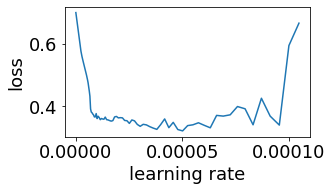

In [0]:
from matplotlib.pyplot import figure
figure(figsize = (5,3)) #figsize=(8,6)
plt.rcParams.update({'figure.autolayout': True, 'font.size':18}) #,
plt.plot(r.history['lr'], r.history['val_loss'])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

Building Bi-LSTM model...
Training model...
lr: 1.1481536214968828e-08
lr: 1.202264434617413e-08
lr: 1.2589254117941673e-08
lr: 1.3182567385564071e-08
lr: 1.3803842646028848e-08
lr: 1.4454397707459274e-08
lr: 1.5135612484362082e-08
lr: 1.5848931924611136e-08
lr: 1.6595869074375607e-08
lr: 1.7378008287493753e-08
lr: 1.8197008586099835e-08
lr: 1.9054607179632472e-08
lr: 1.9952623149688796e-08
lr: 2.0892961308540398e-08
lr: 2.1877616239495524e-08
lr: 2.2908676527677733e-08
lr: 2.3988329190194904e-08
lr: 2.51188643150958e-08
lr: 2.6302679918953818e-08
lr: 2.7542287033381663e-08
lr: 2.884031503126606e-08
lr: 3.019951720402016e-08
lr: 3.16227766016838e-08
lr: 3.311311214825911e-08
lr: 3.4673685045253164e-08
lr: 3.630780547701014e-08
lr: 3.801893963205611e-08
lr: 3.981071705534972e-08
lr: 4.1686938347033536e-08
lr: 4.36515832240166e-08
lr: 4.570881896148751e-08
lr: 4.786300923226384e-08
lr: 5.011872336272722e-08
lr: 5.248074602497726e-08
lr: 5.4954087385762456e-08
lr: 5.75439937337157e-08
lr:

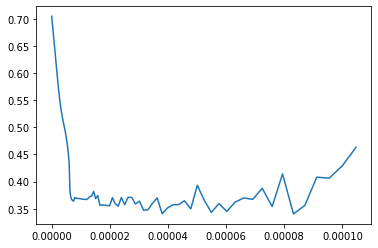

1084/1084 [==============================] - 1s 478us/sample - loss: 0.4909 - tp: 339.0000 - fp: 121.0000 - tn: 539.0000 - fn: 85.0000 - accuracy: 0.8100 - precision: 0.7370 - recall: 0.7995 - auc: 0.8914


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset

from keras.callbacks import LearningRateScheduler

print('Building Bi-LSTM model...')
cvscores = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc', 'learning_rate'])

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


sd=[]
# define loss history to record losses while changing learning rate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))



model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
      tf.keras.layers.LSTM(32, return_sequences=True),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])


optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer,
  metrics = METRICS,

)

# learning rate will change from 1e-7 to 1e-3
def step_decay(losses):
        lrate=1e-8 * 10**(len(history.losses) / 50)
        momentum=0.8
        decay_rate=2e-6
        return lrate

history=LossHistory()
lrate=LearningRateScheduler(step_decay)

# Training model:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, restore_best_weights=True)

print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  verbose = 0,
  callbacks=[history, lrate]
)



model.summary()

# lr
plt.plot(r.history['lr'], r.history['val_loss'])
plt.show()

#scores = saved_model.evaluate(x = texts[test], y = labels[test])
scores = model.evaluate(x = X_test, y = y_test)
idx = r.history['loss'].index(min(r.history['loss'])) # select the learning rate with lowest loss
cvscores = cvscores.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                            'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                            'auc': scores[8], 'learning_rate': r.history['lr'][idx]}, ignore_index=True)

In [0]:
idx = r.history['val_loss'].index(min(r.history['val_loss']))

In [0]:
r.history['lr'][idx]

8.3176375e-05

In [0]:
cvscores.mean(axis = 0)

tp               1396.500000
fp                 11.000000
tn               3274.500000
fn                733.500000
accuracy            0.862524
precision           0.992356
recall              0.655634
auc                 0.911637
learning_rate       0.001000
dtype: float64

#### Models - early stopping

##### LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/200
8772/8772 [==============================] - 30s 3ms/sample - loss: 0.6133 - tp: 1175.0000 - fp: 90.0000 - tn: 5253.0000 - fn: 2254.0000 - accuracy: 0.7328 - precision: 0.9289 - recall: 0.3427 - auc: 0.7202 - val_loss: 0.5676 - val_tp: 118.0000 - val_fp: 0.0000e+00 - val_tn: 570.0000 - val_fn: 287.0000 - val_accuracy: 0.7056 - val_precision: 1.0000 - val_recall: 0.2914 - val_auc: 0.8050
Epoch 2/200
8772/8772 [==============================] - 27s 3ms/sample - loss: 0.4955 - tp: 1365.0000 - fp: 1.0000 - tn: 5342.0000 - fn: 2064.0000 - accuracy: 0.7646 - precision: 0.9993 - recall: 0.3981 - auc: 0.8397 - val_loss: 0.4699 - val_tp: 241.0000 - val_fp: 0.0000e+00 - val_tn: 570.0000 - val_fn: 164.0000 - val_accuracy: 0.8318 - val_precision: 1.0000 - val_recall: 0.5951 - val_auc: 0.8187
Epoch 3/200
8772/8772 [==============================] - 26s 3ms/sample - loss: 0.3622 - tp: 2312.0000 - f

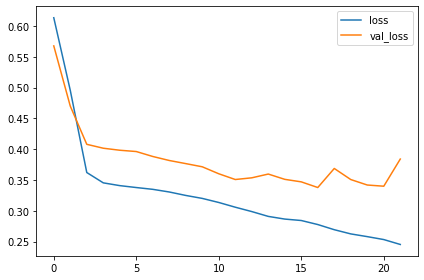

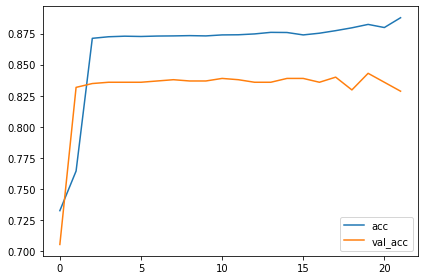

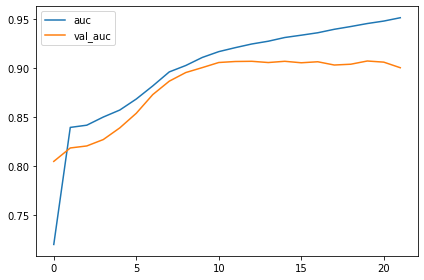

1084/1084 [==============================] - 1s 466us/sample - loss: 0.3241 - tp: 280.0000 - fp: 2.0000 - tn: 656.0000 - fn: 146.0000 - accuracy: 0.8635 - precision: 0.9929 - recall: 0.6573 - auc: 0.9077
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6086 - tp: 1144.0000 - fp: 117.0000 - tn: 5224.0000 - fn: 2288.0000 - accuracy: 0.7259 - precision: 0.9072 - recall: 0.3333 - auc: 0.7155 - val_loss: 0.5509 - val_tp: 129.0000 - val_fp: 0.0000e+00 - val_tn: 573.0000 - val_fn: 273.0000 - val_accuracy: 0.7200 - val_precision: 1.0000 - val_recall: 0.3209 - val_auc: 0.8022
Epoch 2/200
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.4961 - tp: 1326.0000 - fp: 2.0000 - tn: 5339.0000 - fn: 2106.0000 - accuracy: 0.7597 - precision: 0.9985 - recall: 0.3864 - auc: 0.8304 - val_loss: 0.4525 - val_tp: 251.0000 - val_fp: 3.0000 - val_tn: 570.0000 - val_fn: 151.0000 - val_accuracy: 0

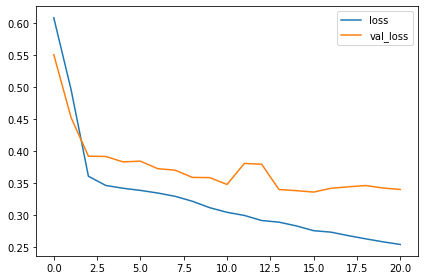

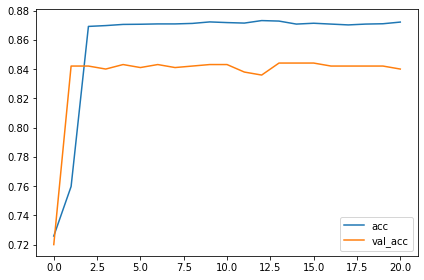

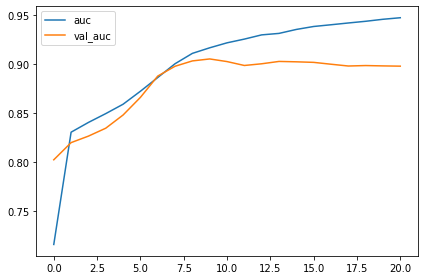

1083/1083 [==============================] - 1s 494us/sample - loss: 0.3022 - tp: 283.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 143.0000 - accuracy: 0.8680 - precision: 1.0000 - recall: 0.6643 - auc: 0.9170
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6077 - tp: 997.0000 - fp: 0.0000e+00 - tn: 5331.0000 - fn: 2445.0000 - accuracy: 0.7213 - precision: 1.0000 - recall: 0.2897 - auc: 0.7331 - val_loss: 0.5595 - val_tp: 122.0000 - val_fp: 0.0000e+00 - val_tn: 583.0000 - val_fn: 270.0000 - val_accuracy: 0.7231 - val_precision: 1.0000 - val_recall: 0.3112 - val_auc: 0.8012
Epoch 2/200
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.4910 - tp: 1521.0000 - fp: 1.0000 - tn: 5330.0000 - fn: 1921.0000 - accuracy: 0.7809 - precision: 0.9993 - recall: 0.4419 - auc: 0.8331 - val_loss: 0.4575 - val_tp: 242.0000 - val_fp: 4.0000 - val_tn: 579.0000 - val_fn: 150.0000 - val_accura

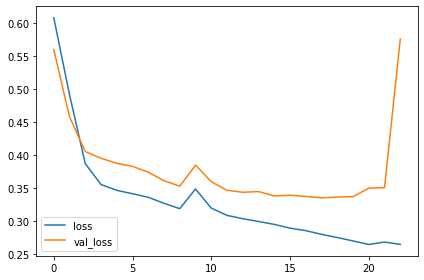

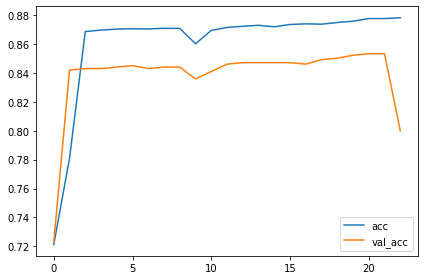

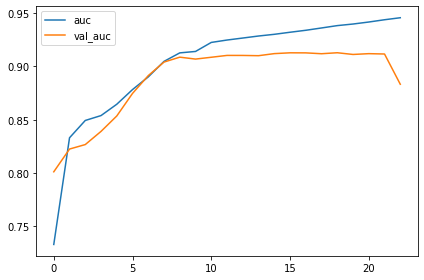

1083/1083 [==============================] - 1s 492us/sample - loss: 0.3180 - tp: 288.0000 - fp: 2.0000 - tn: 655.0000 - fn: 138.0000 - accuracy: 0.8707 - precision: 0.9931 - recall: 0.6761 - auc: 0.9083
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6355 - tp: 1205.0000 - fp: 316.0000 - tn: 5022.0000 - fn: 2230.0000 - accuracy: 0.7098 - precision: 0.7922 - recall: 0.3508 - auc: 0.7098 - val_loss: 0.5803 - val_tp: 123.0000 - val_fp: 0.0000e+00 - val_tn: 576.0000 - val_fn: 276.0000 - val_accuracy: 0.7169 - val_precision: 1.0000 - val_recall: 0.3083 - val_auc: 0.8065
Epoch 2/200
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.5101 - tp: 1280.0000 - fp: 0.0000e+00 - tn: 5338.0000 - fn: 2155.0000 - accuracy: 0.7544 - precision: 1.0000 - recall: 0.3726 - auc: 0.8353 - val_loss: 0.4743 - val_tp: 231.0000 - val_fp: 1.0000 - val_tn: 575.0000 - val_fn: 168.0000 - val_accurac

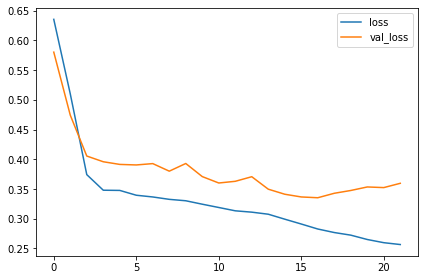

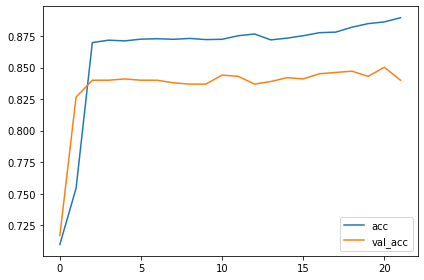

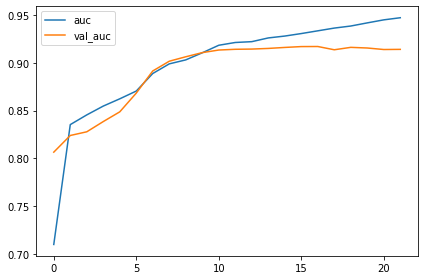

1083/1083 [==============================] - 1s 486us/sample - loss: 0.3177 - tp: 287.0000 - fp: 10.0000 - tn: 647.0000 - fn: 139.0000 - accuracy: 0.8624 - precision: 0.9663 - recall: 0.6737 - auc: 0.9106
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 31s 4ms/sample - loss: 0.6384 - tp: 1599.0000 - fp: 407.0000 - tn: 4933.0000 - fn: 1834.0000 - accuracy: 0.7446 - precision: 0.7971 - recall: 0.4658 - auc: 0.7599 - val_loss: 0.5840 - val_tp: 143.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 258.0000 - val_accuracy: 0.7354 - val_precision: 1.0000 - val_recall: 0.3566 - val_auc: 0.8000
Epoch 2/200
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.4986 - tp: 1970.0000 - fp: 9.0000 - tn: 5331.0000 - fn: 1463.0000 - accuracy: 0.8322 - precision: 0.9955 - recall: 0.5738 - auc: 0.8249 - val_loss: 0.4194 - val_tp: 245.0000 - val_fp: 4.0000 - val_tn: 570.0000 - val_fn: 156.0000 - val_accuracy: 

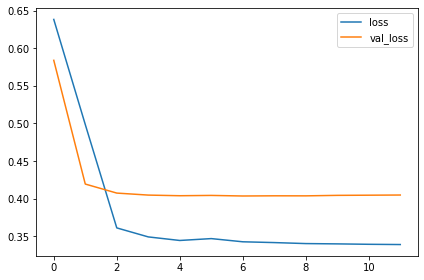

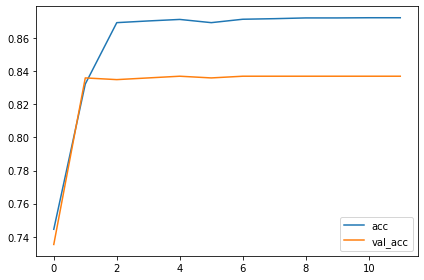

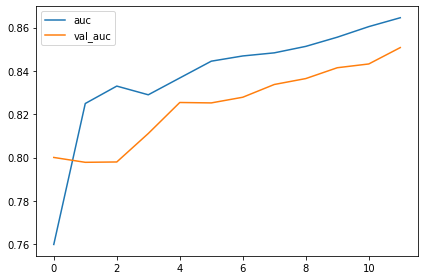

1083/1083 [==============================] - 1s 470us/sample - loss: 0.3647 - tp: 272.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 154.0000 - accuracy: 0.8578 - precision: 1.0000 - recall: 0.6385 - auc: 0.8430
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6240 - tp: 1120.0000 - fp: 16.0000 - tn: 5326.0000 - fn: 2311.0000 - accuracy: 0.7348 - precision: 0.9859 - recall: 0.3264 - auc: 0.7452 - val_loss: 0.5779 - val_tp: 118.0000 - val_fp: 0.0000e+00 - val_tn: 572.0000 - val_fn: 285.0000 - val_accuracy: 0.7077 - val_precision: 1.0000 - val_recall: 0.2928 - val_auc: 0.8029
Epoch 2/200
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.5070 - tp: 1274.0000 - fp: 1.0000 - tn: 5341.0000 - fn: 2157.0000 - accuracy: 0.7540 - precision: 0.9992 - recall: 0.3713 - auc: 0.8298 - val_loss: 0.4796 - val_tp: 245.0000 - val_fp: 1.0000 - val_tn: 571.0000 - val_fn: 158.0000 - val_accuracy

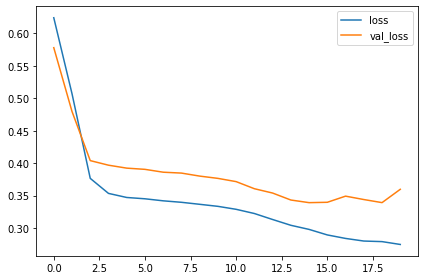

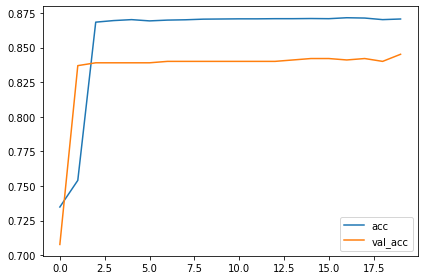

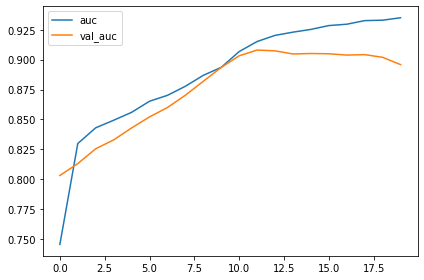

1083/1083 [==============================] - 0s 456us/sample - loss: 0.2973 - tp: 297.0000 - fp: 2.0000 - tn: 655.0000 - fn: 129.0000 - accuracy: 0.8790 - precision: 0.9933 - recall: 0.6972 - auc: 0.9213
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6216 - tp: 875.0000 - fp: 0.0000e+00 - tn: 5339.0000 - fn: 2559.0000 - accuracy: 0.7083 - precision: 1.0000 - recall: 0.2548 - auc: 0.7474 - val_loss: 0.5824 - val_tp: 129.0000 - val_fp: 0.0000e+00 - val_tn: 575.0000 - val_fn: 271.0000 - val_accuracy: 0.7221 - val_precision: 1.0000 - val_recall: 0.3225 - val_auc: 0.8125
Epoch 2/200
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.5287 - tp: 1162.0000 - fp: 0.0000e+00 - tn: 5339.0000 - fn: 2272.0000 - accuracy: 0.7410 - precision: 1.0000 - recall: 0.3384 - auc: 0.8352 - val_loss: 0.5117 - val_tp: 134.0000 - val_fp: 0.0000e+00 - val_tn: 575.0000 - val_fn: 266.0000 - val_ac

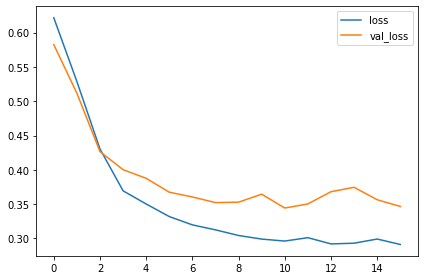

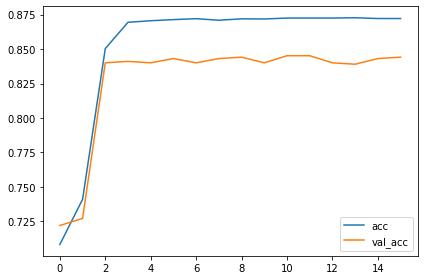

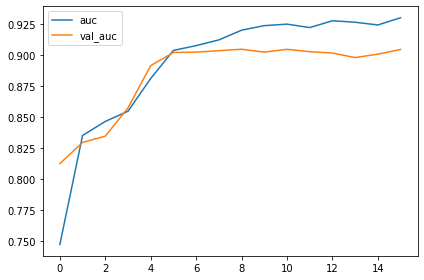

1083/1083 [==============================] - 1s 478us/sample - loss: 0.3284 - tp: 283.0000 - fp: 2.0000 - tn: 655.0000 - fn: 143.0000 - accuracy: 0.8661 - precision: 0.9930 - recall: 0.6643 - auc: 0.9055
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.5918 - tp: 1073.0000 - fp: 0.0000e+00 - tn: 5343.0000 - fn: 2357.0000 - accuracy: 0.7313 - precision: 1.0000 - recall: 0.3128 - auc: 0.7857 - val_loss: 0.5389 - val_tp: 125.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 279.0000 - val_accuracy: 0.7138 - val_precision: 1.0000 - val_recall: 0.3094 - val_auc: 0.8197
Epoch 2/200
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.4506 - tp: 1843.0000 - fp: 5.0000 - tn: 5338.0000 - fn: 1587.0000 - accuracy: 0.8185 - precision: 0.9973 - recall: 0.5373 - auc: 0.8357 - val_loss: 0.4035 - val_tp: 253.0000 - val_fp: 1.0000 - val_tn: 570.0000 - val_fn: 151.0000 - val_accuracy:

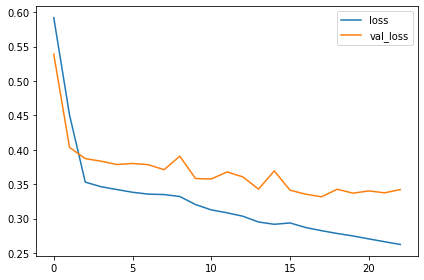

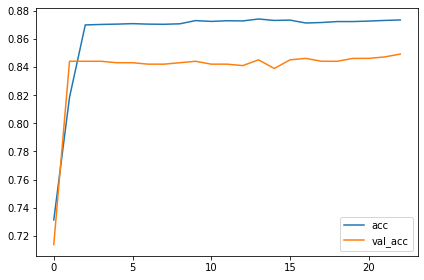

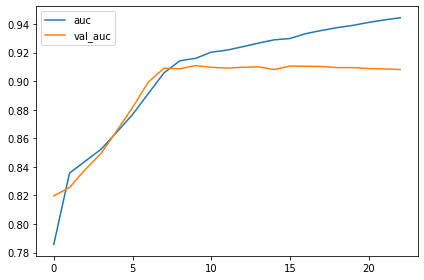

1083/1083 [==============================] - 1s 470us/sample - loss: 0.2990 - tp: 288.0000 - fp: 1.0000 - tn: 656.0000 - fn: 138.0000 - accuracy: 0.8717 - precision: 0.9965 - recall: 0.6761 - auc: 0.9177
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.6048 - tp: 944.0000 - fp: 0.0000e+00 - tn: 5324.0000 - fn: 2505.0000 - accuracy: 0.7145 - precision: 1.0000 - recall: 0.2737 - auc: 0.7549 - val_loss: 0.5527 - val_tp: 123.0000 - val_fp: 0.0000e+00 - val_tn: 590.0000 - val_fn: 262.0000 - val_accuracy: 0.7313 - val_precision: 1.0000 - val_recall: 0.3195 - val_auc: 0.8258
Epoch 2/200
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.4986 - tp: 1369.0000 - fp: 0.0000e+00 - tn: 5324.0000 - fn: 2080.0000 - accuracy: 0.7629 - precision: 1.0000 - recall: 0.3969 - auc: 0.8358 - val_loss: 0.4493 - val_tp: 240.0000 - val_fp: 0.0000e+00 - val_tn: 590.0000 - val_fn: 145.0000 - val_ac

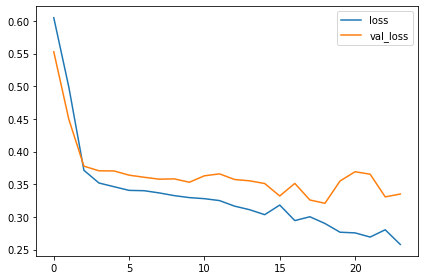

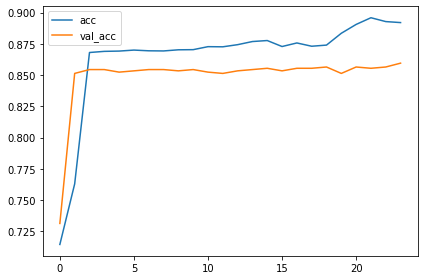

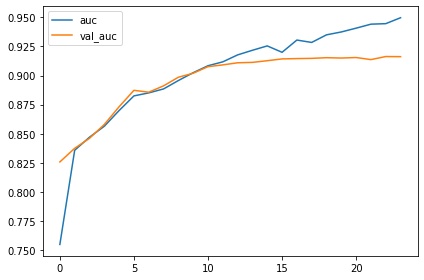

1083/1083 [==============================] - 1s 471us/sample - loss: 0.3089 - tp: 288.0000 - fp: 4.0000 - tn: 653.0000 - fn: 138.0000 - accuracy: 0.8689 - precision: 0.9863 - recall: 0.6761 - auc: 0.9183
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.6011 - tp: 1060.0000 - fp: 1.0000 - tn: 5341.0000 - fn: 2371.0000 - accuracy: 0.7296 - precision: 0.9991 - recall: 0.3089 - auc: 0.7473 - val_loss: 0.5602 - val_tp: 126.0000 - val_fp: 0.0000e+00 - val_tn: 572.0000 - val_fn: 277.0000 - val_accuracy: 0.7159 - val_precision: 1.0000 - val_recall: 0.3127 - val_auc: 0.8107
Epoch 2/200
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.4849 - tp: 1590.0000 - fp: 2.0000 - tn: 5340.0000 - fn: 1841.0000 - accuracy: 0.7899 - precision: 0.9987 - recall: 0.4634 - auc: 0.8379 - val_loss: 0.4523 - val_tp: 249.0000 - val_fp: 0.0000e+00 - val_tn: 572.0000 - val_fn: 154.0000 - val_accuracy:

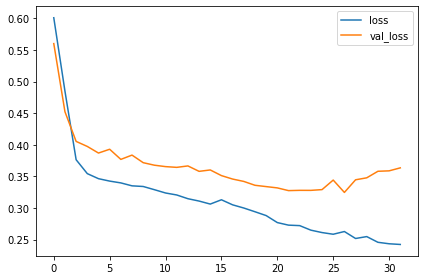

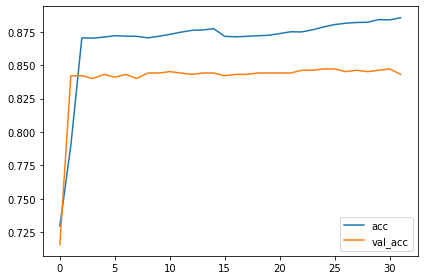

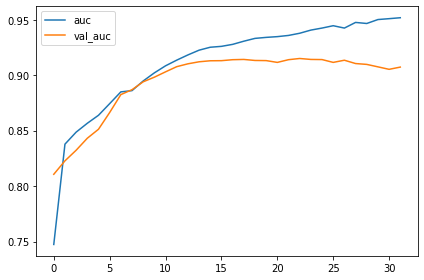

1083/1083 [==============================] - 1s 463us/sample - loss: 0.3202 - tp: 297.0000 - fp: 14.0000 - tn: 643.0000 - fn: 129.0000 - accuracy: 0.8680 - precision: 0.9550 - recall: 0.6972 - auc: 0.9145


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_lstm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
       tf.keras.layers.LSTM(32, return_sequences=True),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(16, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_lstm = cvscores_lstm.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_lstm

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,280.0,2.0,656.0,146.0,0.863469,0.992908,0.657277,0.790960,0.907727,0.695695
1,283.0,0.0,657.0,143.0,0.867959,1.000000,0.664319,0.798307,0.916979,0.705981
2,288.0,2.0,655.0,138.0,0.870729,0.993103,0.676056,0.804469,0.908302,0.713030
3,287.0,10.0,647.0,139.0,0.862419,0.966330,0.673709,0.793914,0.910648,0.695514
4,272.0,0.0,657.0,154.0,0.857802,1.000000,0.638498,0.779370,0.843023,0.681829
5,297.0,2.0,655.0,129.0,0.879040,0.993311,0.697183,0.819310,0.921261,0.732531
6,283.0,2.0,655.0,143.0,0.866113,0.992982,0.664319,0.796062,0.905501,0.702130
7,288.0,1.0,656.0,138.0,0.871653,0.996540,0.676056,0.805594,0.917674,0.714955
8,288.0,4.0,653.0,138.0,0.868883,0.986301,0.676056,0.802228,0.918350,0.709185
9,297.0,14.0,643.0,129.0,0.867959,0.954984,0.697183,0.805970,0.914546,0.709547


In [0]:
cvscores_lstm.mean()

tp                   286.300000
fp                     3.700000
tn                   653.400000
fn                   139.700000
accuracy               0.867603
precision              0.987646
recall                 0.672066
f1                     0.799619
auc                    0.906401
cohen-kappa-score      0.706040
dtype: float64

In [0]:
cvscores_lstm.to_csv("/gdrive/My Drive/lstm.csv")

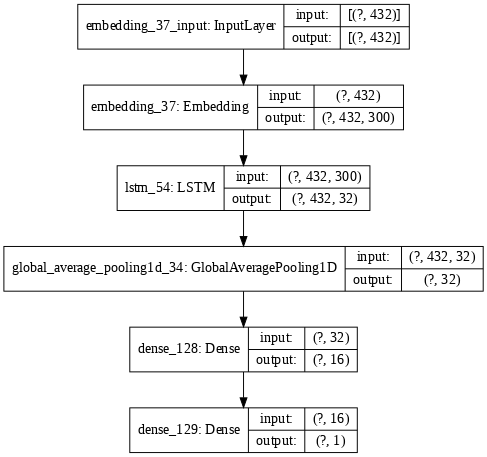

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_lstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### LSTM + tf-idf (concatenate)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# calculate Tfidf vector
word_vectorizer = TfidfVectorizer(
    max_features=500)

word_vectorizer.fit(data_cleaned['texts'])
tf_idf = word_vectorizer.transform(data_cleaned['texts'])
tf_idf = tf_idf.toarray()

In [0]:
texts_tf= np.concatenate([texts, tf_idf], axis = 1)  # concatenate word embedding and Tfidf vectors

Building Bi-LSTM model...
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_49[0][0]                   
__________________________________________________________________________________________________
layer_normalization_24 (LayerNo (None, 500)          1000        input_50[0][0]                   
_________________________________________________________________

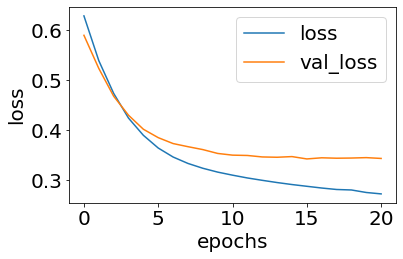

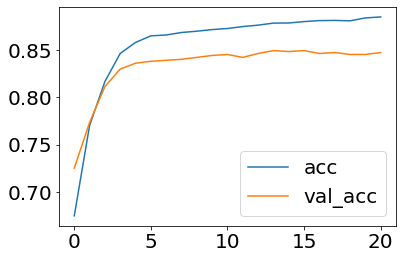

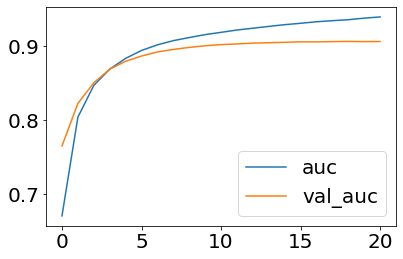

1084/1084 [==============================] - 1s 488us/sample - loss: 0.3265 - tp: 307.0000 - fp: 26.0000 - tn: 632.0000 - fn: 119.0000 - accuracy: 0.8662 - precision: 0.9219 - recall: 0.7207 - auc: 0.9018
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_51[0][0]                   
____________________________________________________________________________________

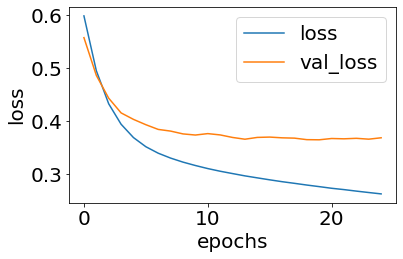

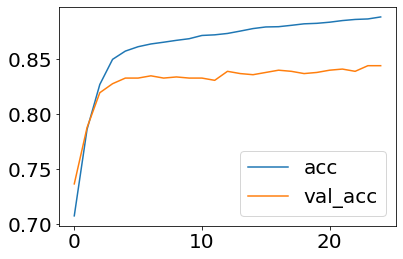

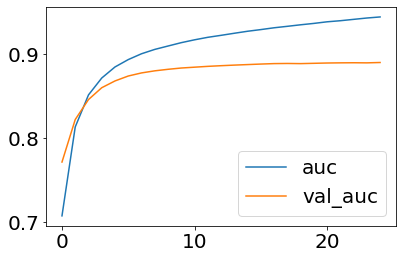

1083/1083 [==============================] - 1s 494us/sample - loss: 0.3137 - tp: 319.0000 - fp: 33.0000 - tn: 624.0000 - fn: 107.0000 - accuracy: 0.8707 - precision: 0.9062 - recall: 0.7488 - auc: 0.9109
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_53[0][0]                   
____________________________________________________________________________________

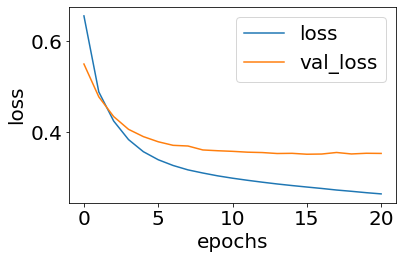

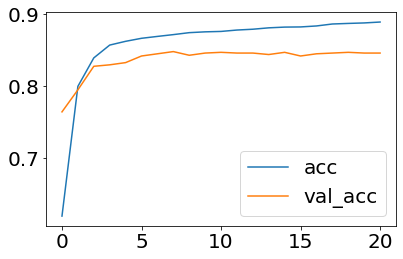

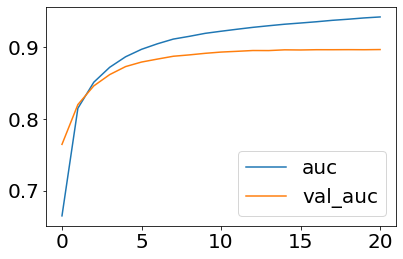

1083/1083 [==============================] - 1s 508us/sample - loss: 0.3248 - tp: 303.0000 - fp: 27.0000 - tn: 630.0000 - fn: 123.0000 - accuracy: 0.8615 - precision: 0.9182 - recall: 0.7113 - auc: 0.9032
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_55[0][0]                   
____________________________________________________________________________________

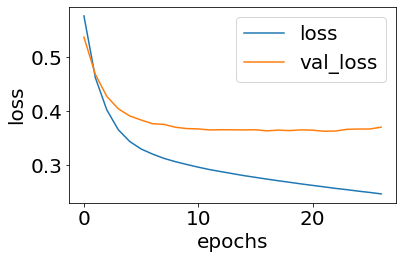

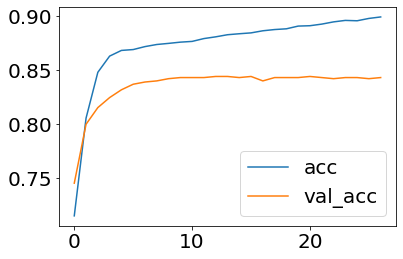

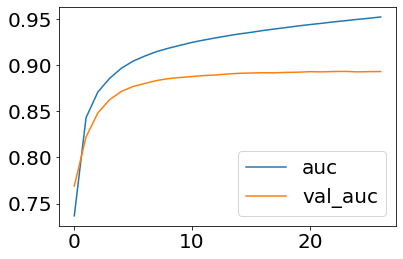

1083/1083 [==============================] - 1s 510us/sample - loss: 0.3301 - tp: 310.0000 - fp: 39.0000 - tn: 618.0000 - fn: 116.0000 - accuracy: 0.8569 - precision: 0.8883 - recall: 0.7277 - auc: 0.9076
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_57[0][0]                   
____________________________________________________________________________________

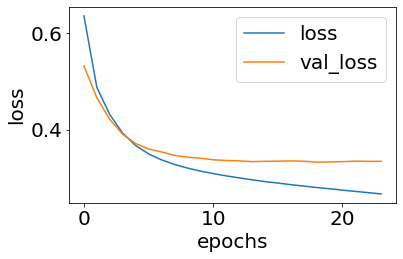

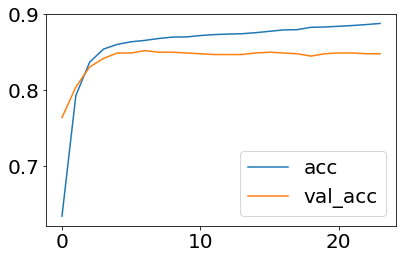

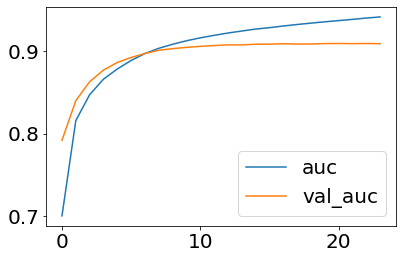

1083/1083 [==============================] - 1s 491us/sample - loss: 0.3271 - tp: 313.0000 - fp: 34.0000 - tn: 623.0000 - fn: 113.0000 - accuracy: 0.8643 - precision: 0.9020 - recall: 0.7347 - auc: 0.8980
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_59[0][0]                   
____________________________________________________________________________________

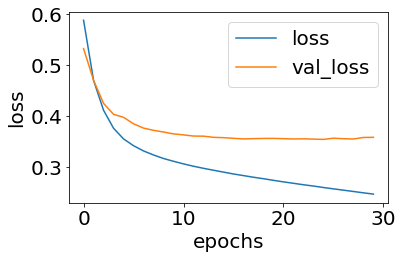

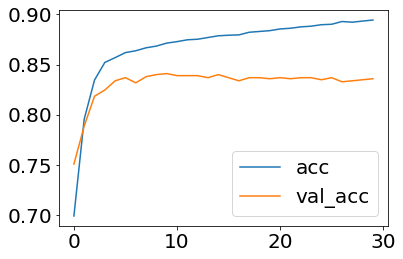

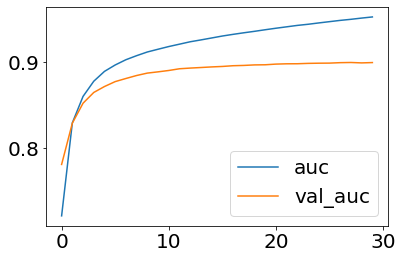

1083/1083 [==============================] - 1s 483us/sample - loss: 0.3178 - tp: 316.0000 - fp: 38.0000 - tn: 619.0000 - fn: 110.0000 - accuracy: 0.8633 - precision: 0.8927 - recall: 0.7418 - auc: 0.9108
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_61[0][0]                   
____________________________________________________________________________________

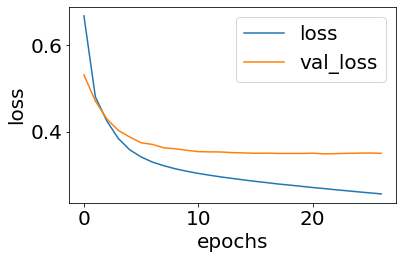

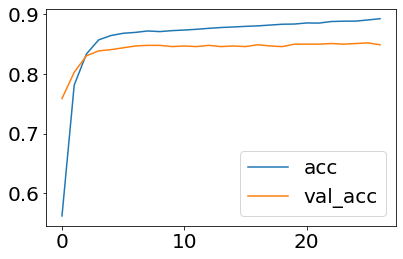

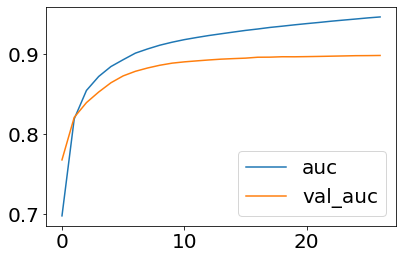

1083/1083 [==============================] - 1s 497us/sample - loss: 0.3223 - tp: 300.0000 - fp: 30.0000 - tn: 627.0000 - fn: 126.0000 - accuracy: 0.8560 - precision: 0.9091 - recall: 0.7042 - auc: 0.9103
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_63[0][0]                   
____________________________________________________________________________________

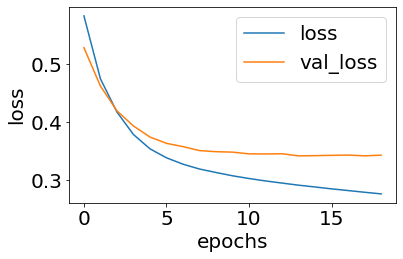

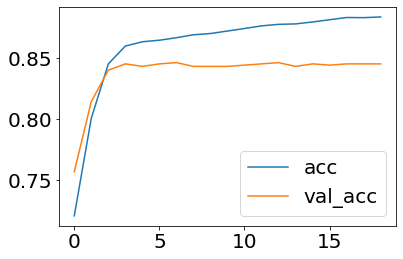

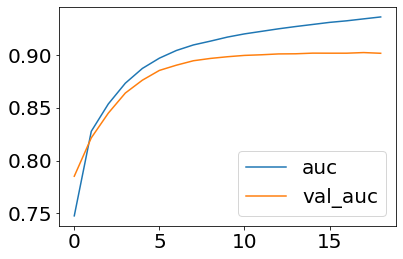

1083/1083 [==============================] - 1s 472us/sample - loss: 0.3248 - tp: 303.0000 - fp: 25.0000 - tn: 632.0000 - fn: 123.0000 - accuracy: 0.8633 - precision: 0.9238 - recall: 0.7113 - auc: 0.9070
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_65[0][0]                   
____________________________________________________________________________________

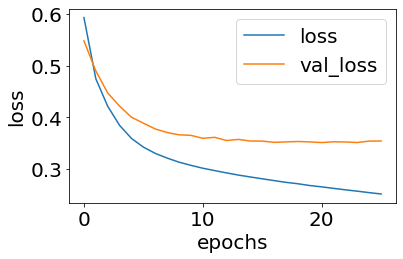

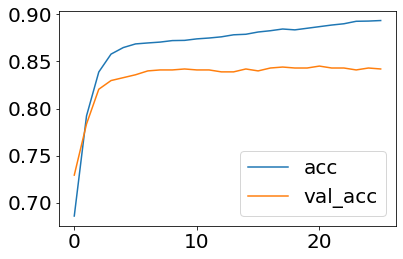

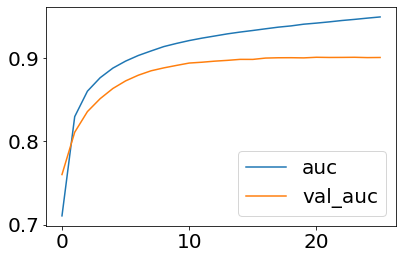

1083/1083 [==============================] - 1s 493us/sample - loss: 0.3384 - tp: 294.0000 - fp: 29.0000 - tn: 628.0000 - fn: 132.0000 - accuracy: 0.8513 - precision: 0.9102 - recall: 0.6901 - auc: 0.8986
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 432, 300)     12874200    input_67[0][0]                   
____________________________________________________________________________________

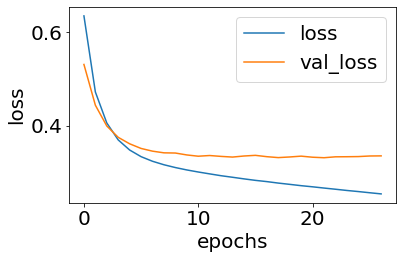

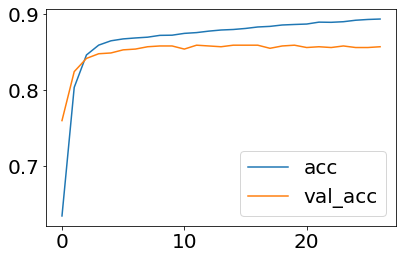

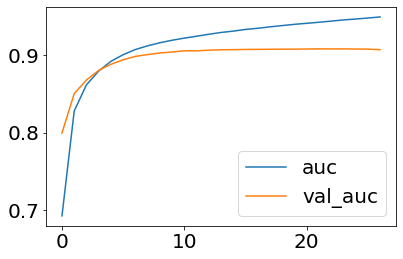

1083/1083 [==============================] - 1s 495us/sample - loss: 0.3472 - tp: 306.0000 - fp: 36.0000 - tn: 621.0000 - fn: 120.0000 - accuracy: 0.8560 - precision: 0.8947 - recall: 0.7183 - auc: 0.8941


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 9)
cvscores_lstm_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]



embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))  # input layer for word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.LSTM(32)(x)   # LSTM layer on embedding layer
  #x = tf.keras.layers.Dense(16, activation='relu')(x)  

  input_2 = tf.keras.Input(shape=(500,))  # input layer for Tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec)  # reduce the dimension of Tfidf layer to 32

  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  model.summary()
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #verbose = 0,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()
  
  
  plt.rcParams.update({'figure.autolayout': True, 'font.size':20})
# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_lstm_tf = cvscores_lstm_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_lstm_tf

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,307.0,26.0,632.0,119.0,0.866236,0.921922,0.720657,0.808959,0.901758,0.708408
1,319.0,33.0,624.0,107.0,0.870729,0.906250,0.748826,0.820051,0.910895,0.720604
2,303.0,27.0,630.0,123.0,0.861496,0.918182,0.711268,0.801587,0.903175,0.697817
3,310.0,39.0,618.0,116.0,0.856879,0.888252,0.727700,0.800000,0.907645,0.690273
4,313.0,34.0,623.0,113.0,0.864266,0.902017,0.734742,0.809832,0.897984,0.706008
5,316.0,38.0,619.0,110.0,0.863343,0.892655,0.741784,0.810256,0.910848,0.704889
6,300.0,30.0,627.0,126.0,0.855956,0.909091,0.704225,0.793651,0.910335,0.685730
7,303.0,25.0,632.0,123.0,0.863343,0.923781,0.711268,0.803714,0.907041,0.701590
8,294.0,29.0,628.0,132.0,0.851339,0.910217,0.690141,0.785047,0.898616,0.674678
9,306.0,36.0,621.0,120.0,0.855956,0.894737,0.718310,0.796875,0.894086,0.687342


In [0]:
cvscores_lstm_tf.mean()

tp                   307.100000
fp                    31.700000
tn                   625.400000
fn                   118.900000
accuracy               0.860954
precision              0.906710
recall                 0.720892
f1                     0.802997
auc                    0.904238
cohen-kappa-score      0.697734
dtype: float64

In [0]:
cvscores_lstm_tf.to_csv("/gdrive/My Drive/lstm_tf.csv")

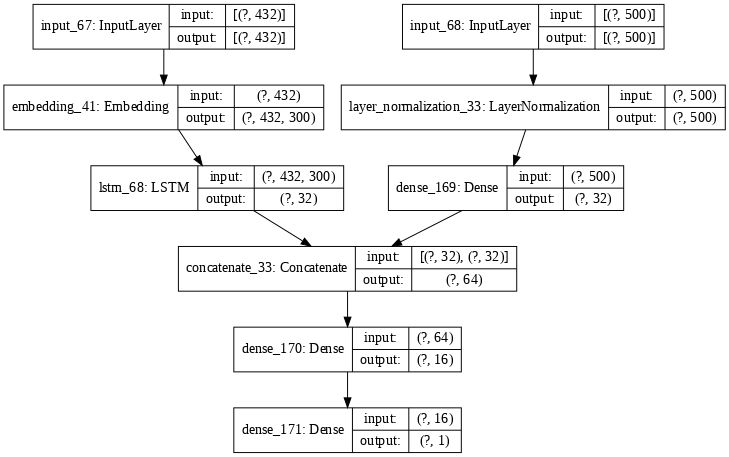

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_lstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### 1D CNN + LSTM + tf-idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# calculate Tfidf vector
word_vectorizer = TfidfVectorizer(
    max_features=500)

word_vectorizer.fit(data_cleaned['texts'])
tf_idf = word_vectorizer.transform(data_cleaned['texts'])
tf_idf = tf_idf.toarray()

In [0]:
texts_tf= np.concatenate([texts, tf_idf], axis = 1)  # concatenate word embedding and Tfidf vectors

Building Bi-LSTM model...
Training model...
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 430, 300)     270300      e

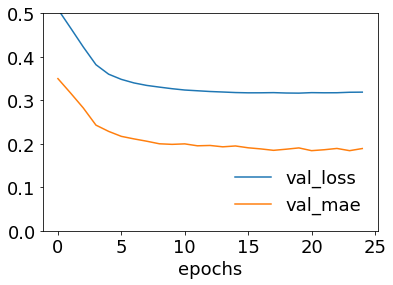

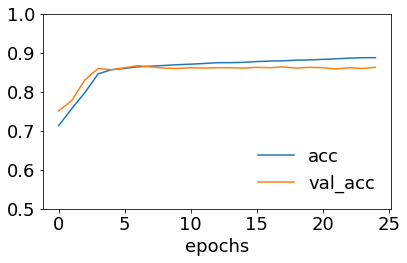

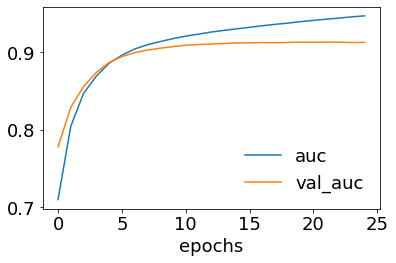

1084/1084 [==============================] - 1s 572us/sample - loss: 0.3498 - tp: 294.0000 - fp: 38.0000 - tn: 620.0000 - fn: 132.0000 - accuracy: 0.8432 - precision: 0.8855 - recall: 0.6901 - auc: 0.8960 - mae: 0.2091
Training model...
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 500)]        0               

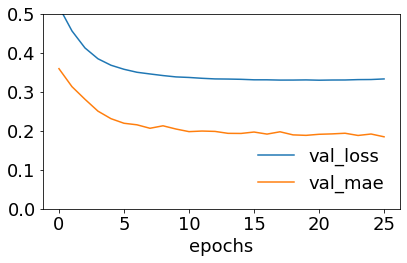

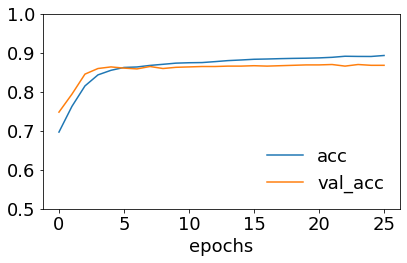

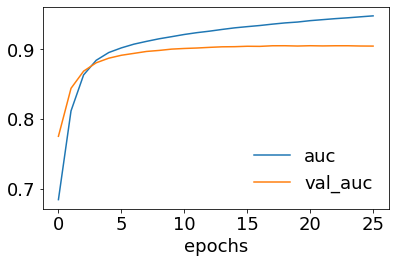

1083/1083 [==============================] - 1s 572us/sample - loss: 0.3447 - tp: 305.0000 - fp: 45.0000 - tn: 612.0000 - fn: 121.0000 - accuracy: 0.8467 - precision: 0.8714 - recall: 0.7160 - auc: 0.8973 - mae: 0.2070
Training model...
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500)]        0               

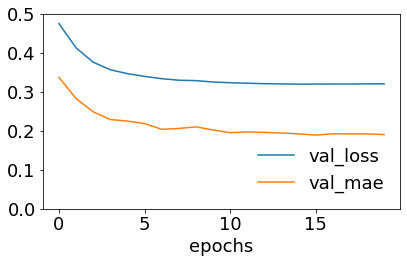

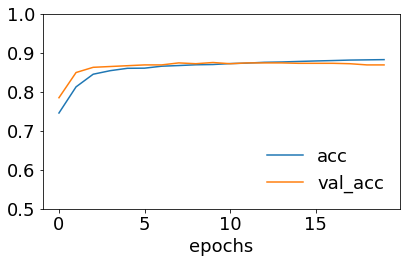

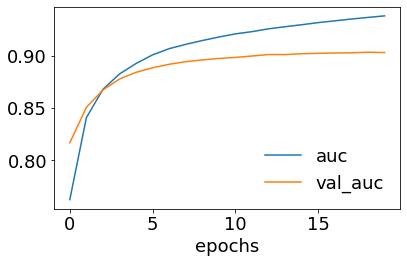

1083/1083 [==============================] - 1s 566us/sample - loss: 0.3303 - tp: 299.0000 - fp: 16.0000 - tn: 641.0000 - fn: 127.0000 - accuracy: 0.8680 - precision: 0.9492 - recall: 0.7019 - auc: 0.8998 - mae: 0.1949
Training model...
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 500)]        0               

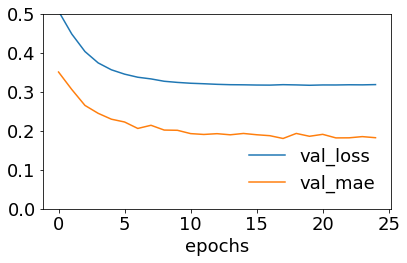

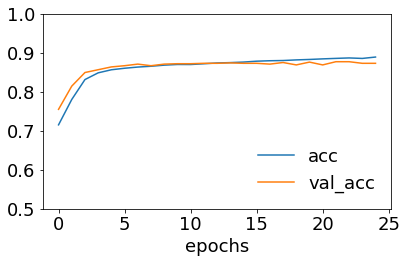

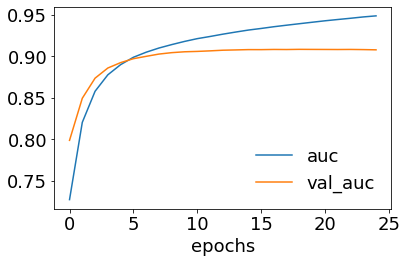

1083/1083 [==============================] - 1s 559us/sample - loss: 0.3449 - tp: 298.0000 - fp: 25.0000 - tn: 632.0000 - fn: 128.0000 - accuracy: 0.8587 - precision: 0.9226 - recall: 0.6995 - auc: 0.8984 - mae: 0.1999
Training model...
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 500)]        0               

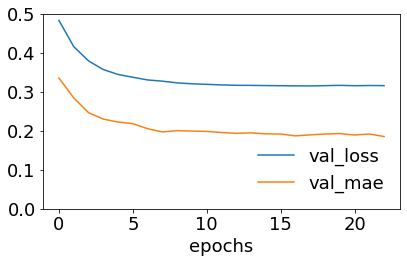

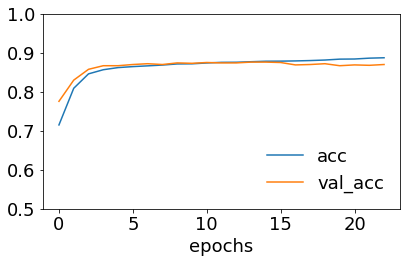

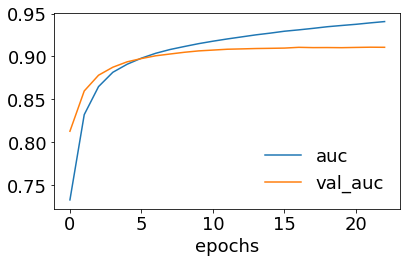

1083/1083 [==============================] - 1s 608us/sample - loss: 0.3277 - tp: 308.0000 - fp: 40.0000 - tn: 617.0000 - fn: 118.0000 - accuracy: 0.8541 - precision: 0.8851 - recall: 0.7230 - auc: 0.9072 - mae: 0.1975
Training model...
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 500)]        0               

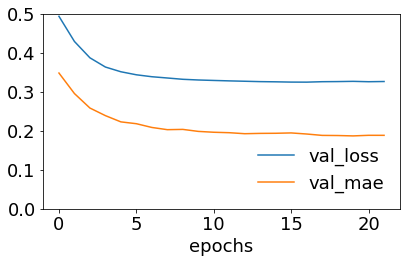

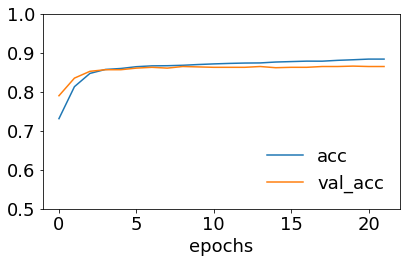

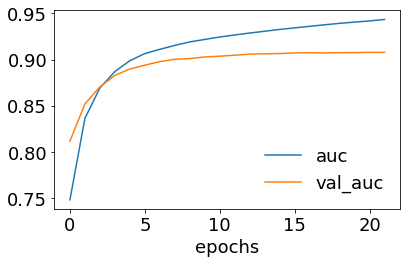

1083/1083 [==============================] - 1s 576us/sample - loss: 0.3404 - tp: 298.0000 - fp: 22.0000 - tn: 635.0000 - fn: 128.0000 - accuracy: 0.8615 - precision: 0.9312 - recall: 0.6995 - auc: 0.8937 - mae: 0.1989
Training model...
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 500)]        0               

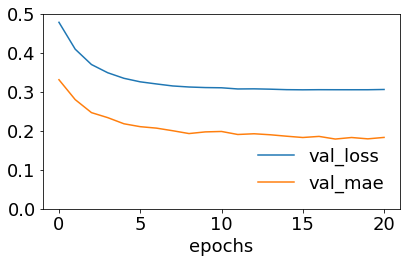

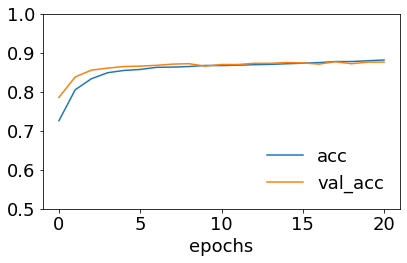

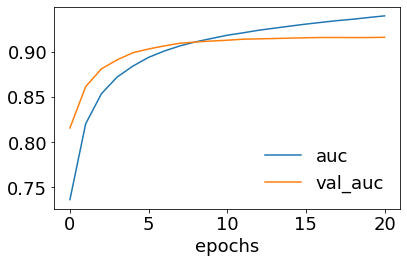

1083/1083 [==============================] - 1s 560us/sample - loss: 0.3158 - tp: 300.0000 - fp: 14.0000 - tn: 643.0000 - fn: 126.0000 - accuracy: 0.8707 - precision: 0.9554 - recall: 0.7042 - auc: 0.9081 - mae: 0.1852
Training model...
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 500)]        0               

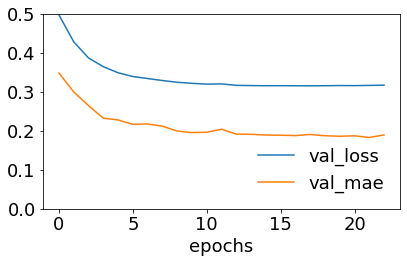

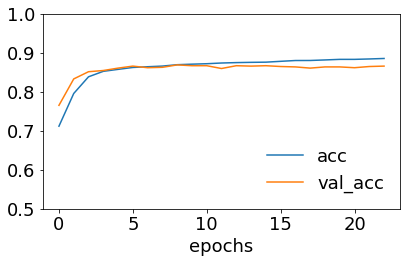

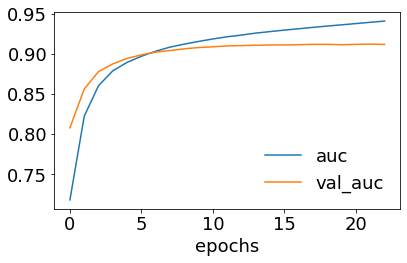

1083/1083 [==============================] - 1s 564us/sample - loss: 0.2938 - tp: 322.0000 - fp: 32.0000 - tn: 625.0000 - fn: 104.0000 - accuracy: 0.8744 - precision: 0.9096 - recall: 0.7559 - auc: 0.9224 - mae: 0.1850
Training model...
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_17[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 500)]        0               

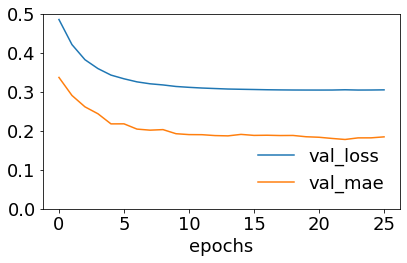

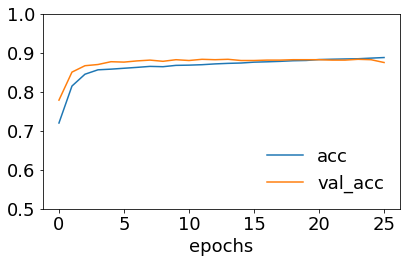

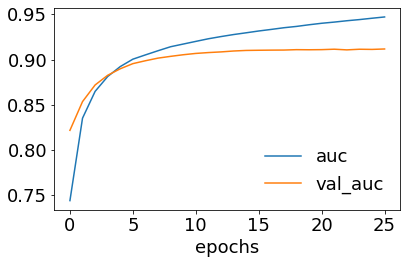

1083/1083 [==============================] - 1s 576us/sample - loss: 0.3308 - tp: 305.0000 - fp: 29.0000 - tn: 628.0000 - fn: 121.0000 - accuracy: 0.8615 - precision: 0.9132 - recall: 0.7160 - auc: 0.9045 - mae: 0.2007
Training model...
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 432, 300)     12866700    input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 500)]        0               

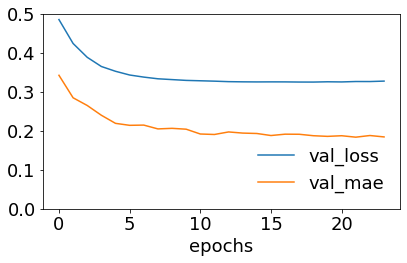

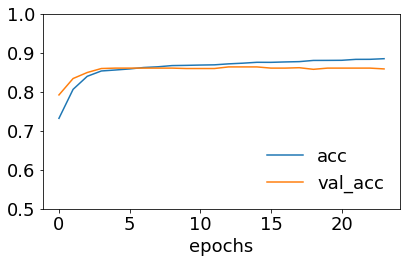

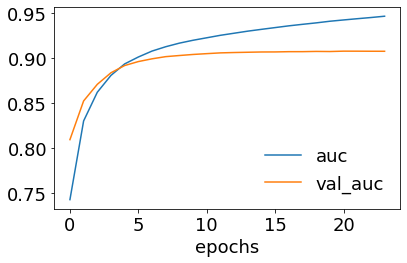

1083/1083 [==============================] - 1s 579us/sample - loss: 0.3124 - tp: 314.0000 - fp: 28.0000 - tn: 629.0000 - fn: 112.0000 - accuracy: 0.8707 - precision: 0.9181 - recall: 0.7371 - auc: 0.9135 - mae: 0.1914


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_bilstm_cnn_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      'mae'
]

embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,)) # input layer using word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.Conv1D(filters = EMBEDDING_DIM, kernel_size = 3, padding='valid', activation='relu')(x)
  x = tf.keras.layers.LSTM(32)(x)   # LSTM layer on embedding layer
 
  input_2 = tf.keras.Input(shape=(500,))  #input layer using tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec) # reduce the dimension of tfidf layer to 32
  
  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r0 = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    verbose = 0,
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()
# plot some data

  figure(figsize=(6,4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r0.history['val_loss'], label='val_loss')
  plt.plot(r0.history['val_mae'], label='val_mae')
  plt.xlabel('epochs')
  plt.ylim(0, 0.5)
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()

# accuracies
  figure(figsize=(6,4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r0.history['accuracy'], label='acc')
  plt.plot(r0.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.ylim(0.5, 1)
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()

# auc
  figure(figsize=(6,4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r0.history['auc'], label='auc')
  plt.plot(r0.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_cnn_tf = cvscores_bilstm_cnn_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_bilstm_cnn_tf

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,294.0,38.0,620.0,132.0,0.843173,0.885542,0.690141,0.775726,0.895970,0.657986
1,305.0,45.0,612.0,121.0,0.846722,0.871429,0.715962,0.786082,0.897280,0.668434
2,299.0,16.0,641.0,127.0,0.867959,0.949206,0.701878,0.807018,0.899795,0.710050
3,298.0,25.0,632.0,128.0,0.858726,0.922601,0.699531,0.795728,0.898355,0.690843
4,308.0,40.0,617.0,118.0,0.854109,0.885057,0.723005,0.795866,0.907156,0.684143
5,298.0,22.0,635.0,128.0,0.861496,0.931250,0.699531,0.798928,0.893709,0.696513
6,300.0,14.0,643.0,126.0,0.870729,0.955414,0.704225,0.810811,0.908140,0.716010
7,322.0,32.0,625.0,104.0,0.874423,0.909605,0.755869,0.825641,0.922401,0.728817
8,305.0,29.0,628.0,121.0,0.861496,0.913174,0.715962,0.802632,0.904463,0.698335
9,314.0,28.0,629.0,112.0,0.870729,0.918129,0.737089,0.817708,0.913485,0.719409


In [0]:
cvscores_bilstm_cnn_tf.mean()

tp                   305.500000
fp                    31.400000
tn                   625.700000
fn                   120.500000
accuracy               0.859754
precision              0.907577
recall                 0.717136
f1                     0.800789
auc                    0.905501
cohen-kappa-score      0.694885
dtype: float64

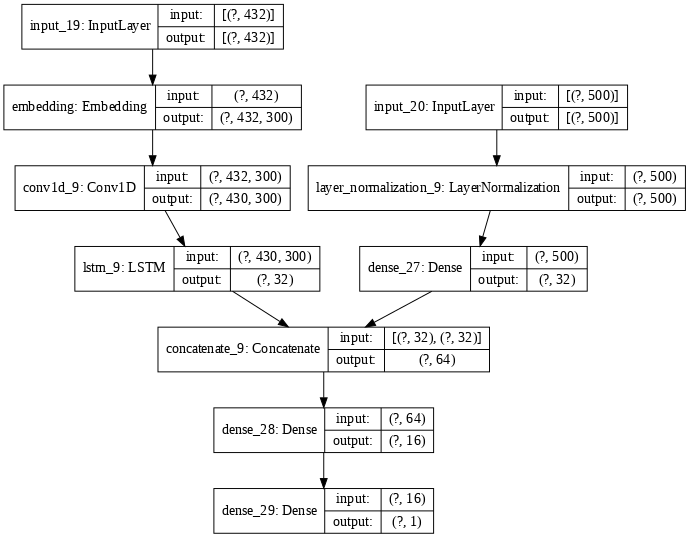

In [0]:
plot_model(model, to_file='model_plot_bilstm_att.png', show_shapes=True, show_layer_names=True, dpi = 70)